In [3]:
import pandas as pd

geoid_miles_seconds = pd.read_csv("geoid-miles-seconds.csv", engine="pyarrow")
built_environment_demographics = pd.read_csv("built-environment-demographics.csv", engine="pyarrow")
trip_info = pd.read_csv("trip-info.csv", engine="pyarrow")

In [4]:
pickups_by_geoid = geoid_miles_seconds["GEOID"].value_counts().reset_index()
pickups_by_geoid.columns = ["GEOID","Pickups"]

In [5]:
import folium
import geopandas as gpd

geodata = gpd.read_file("shapes.geojson")

geodata = geodata[geodata["GEOID"].notna()]
geodata = geodata.astype({"GEOID":"int"}) 

geodata = geodata[geodata["GEOID"].isin(pickups_by_geoid["GEOID"])]
geodata = geodata.to_crs(epsg = 4326)

In [6]:
pickup_map = folium.Map(location = [41.8,-87.6])
pickup_map

In [7]:
folium.Choropleth(
    geo_data=geodata,
    name="choropleth",
    data=pickups_by_geoid,
    columns=["GEOID","Pickups"],
    threshold_scale = [0,50000,100000,150000,200000,300000,500000,750000,1000000, 1200000],
    key_on="feature.properties.GEOID",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Pickups by Census Tract",
).add_to(pickup_map)

folium.LayerControl().add_to(pickup_map)


pickup_map

In [8]:
built_environment_pickup = pd.merge(pickups_by_geoid, built_environment_demographics)
main_df = pd.merge(built_environment_pickup, trip_info, on="GEOID")

In [9]:
main_df.to_csv("main-df.csv", index=False)

In [10]:
main_df.columns

Index(['GEOID', 'Pickups', '_x', 'Unnamed: 0', 'MedianIncome', 'Pickup',
       'TotalPopulation', 'Population_Density', ' Employment_Density',
       'Percent_Zero_Car_Ownership', 'LandUse_Diversity',
       'Distance_from_transit', '_y', 'Trip_Miles', 'Trip_Seconds'],
      dtype='object')

In [43]:
X = main_df[["Pickups","MedianIncome","TotalPopulation","Population_Density"," Employment_Density","Percent_Zero_Car_Ownership","LandUse_Diversity","Distance_from_transit","Trip_Miles","Trip_Seconds"]]


In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sc_X = scaler.fit_transform(X)

In [45]:
sc_X.shape

(895, 10)

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_sc_X = pca.fit_transform(sc_X)

In [60]:
pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]

0.4939656414718555

In [61]:
reduced_sc_X

array([[17.28298397, 18.52809082],
       [ 8.5045062 ,  7.56688787],
       [ 5.52746094,  3.93292005],
       ...,
       [-2.39355409,  0.81874177],
       [-3.02027037,  2.36152849],
       [-2.07132636,  1.46456484]])

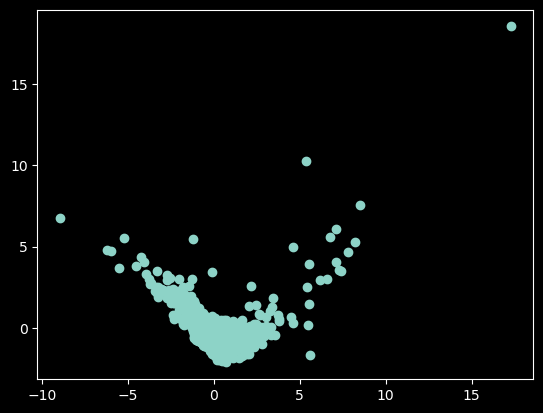

In [62]:
plt.scatter(reduced_sc_X[:,0],reduced_sc_X[:,1])

IndexError: index 2 is out of bounds for axis 1 with size 2

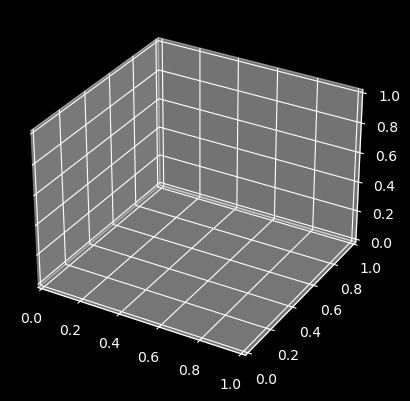

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate sample data (replace this with your own data)
n = 100  # Number of data points
data = reduced_sc_X  # Replace this with your nx3 matrix

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z values from the data matrix
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Create the scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()


In [54]:
from minisom import MiniSom

som = MiniSom(10,10, 2,sigma = 0.1, learning_rate=0.1)
som.random_weights_init(reduced_sc_X)
som.train(reduced_sc_X,1000)

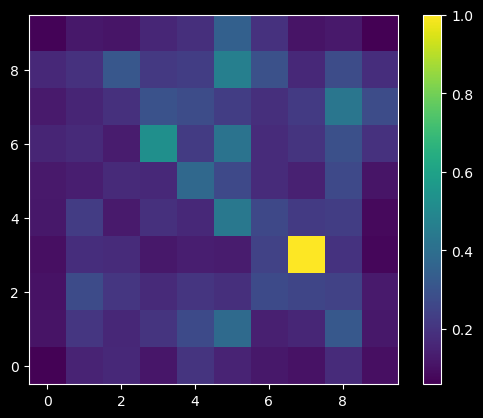

In [55]:
u_matrix = som.distance_map()
import matplotlib.pyplot as plt 
plt.imshow(u_matrix, cmap="viridis", origin="lower")
plt.colorbar()
plt.show()

In [64]:
som.get_weights()

array([[[-1.59799056e-01,  4.08146135e-01],
        [ 2.17646169e+00, -4.57516772e-01],
        [ 2.77611644e+00, -8.18631679e-02],
        [ 6.42652481e-01,  2.09777925e-01],
        [-1.23235181e+00,  7.06834073e-01],
        [ 4.35263512e-02, -1.22628037e+00],
        [-3.31200804e-01,  5.21933867e-01],
        [-8.38590961e-01, -3.07821155e-01],
        [-1.54440464e+00,  9.70399311e-01],
        [ 4.82041543e-01, -1.37982743e+00]],

       [[-5.55230459e-01, -2.80043742e-01],
        [-4.92811791e-01, -8.74088248e-01],
        [-5.89918866e-02, -3.60681075e-01],
        [ 5.60308411e-02, -1.05969366e+00],
        [ 2.20397901e+00, -9.00689786e-01],
        [ 2.68598829e+00,  1.20759010e+00],
        [-7.60094820e-01, -7.16534256e-01],
        [ 4.63436562e-01, -5.84004783e-01],
        [ 2.36072729e+00, -8.27830701e-01],
        [-9.53295630e-01,  4.69219935e-02]],

       [[ 6.44358079e-01,  3.87877925e-01],
        [ 1.68144529e+00, -1.00965130e+00],
        [-1.14258585e+00,  1

In [58]:
som.quantization_error(reduced_sc_X)

0.22873687268085302

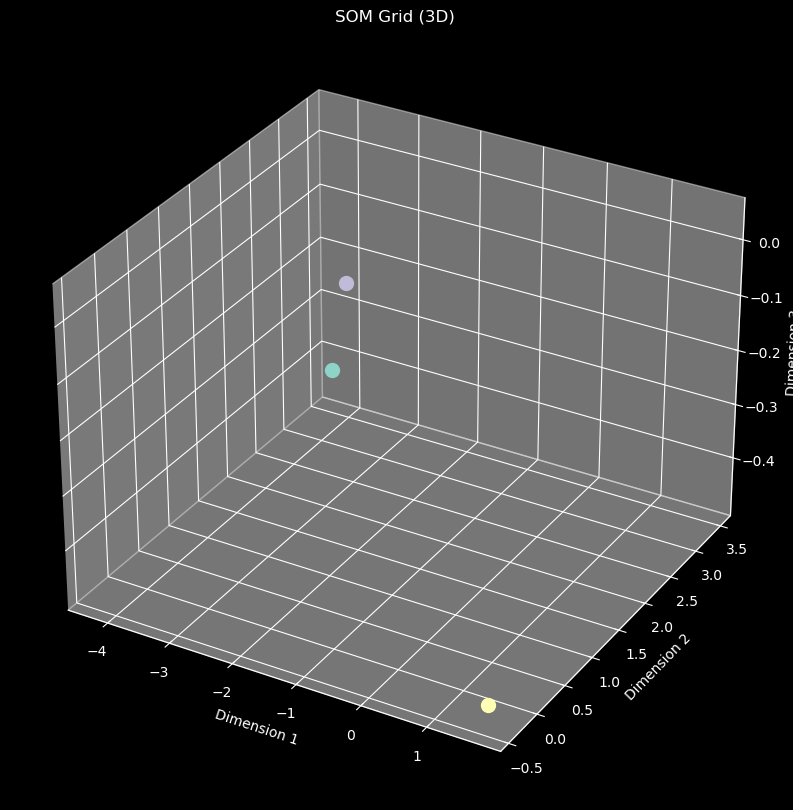

In [23]:
som_weights = som.get_weights()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for x in range(som_weights.shape[0]):
    for y in range(som_weights.shape[1]):
        ax.scatter(som_weights[x, y, 0], som_weights[x, y, 1], som_weights[x, y, 2], s=100)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title('SOM Grid (3D)')
plt.show()


In [24]:
# winner_coordinates = np.array([som.winner(x) for x in reduced_sc_X]).T

In [25]:
# winning_neurons = []
# for data_point in reduced_sc_X:  # Assuming you've scaled your data
#     winner = som.winner(data_point)
#     winning_neurons.append(winner)


In [26]:
# clusters = {}
# for i, winner in enumerate(winning_neurons):
#     if winner in clusters:
#         clusters[winner].append(i)
#     else:
#         clusters[winner] = [i]


In [ ]:
# cluster_data = {}
# for cluster_id, data_indices in clusters.items():
#     cluster_data[cluster_id] = reduced_sc_X[data_indices]


In [ ]:
cluster_data

{(4,
  0): array([[17.28298397, 18.52809082,  7.76521858],
        [ 7.10373631,  6.07840205,  4.69955956],
        [ 5.35412596, 10.2772498 , 13.81194193]]),
 (4,
  2): array([[ 8.5045062 ,  7.56688787, -3.17226439],
        [ 7.79868785,  4.67428289, -2.33112581],
        [ 7.0827706 ,  4.08616195, -2.73220871],
        [ 7.26604206,  3.54166473, -2.04452733],
        [ 6.14852814,  2.98004502, -1.13112733]]),
 (3,
  1): array([[ 5.52746094,  3.93292005,  0.45577727],
        [ 7.41379125,  3.48814934,  0.17905265],
        [ 6.5966175 ,  3.03524992, -0.31604582]]),
 (4,
  1): array([[8.22790022, 5.25917818, 0.25976786],
        [6.7302127 , 5.61756285, 2.84455328]]),
 (4, 3): array([[ 4.6289911 ,  4.97592712, -6.38472084]]),
 (3,
  2): array([[ 5.55365119,  1.46139098, -1.29033494],
        [ 5.38910395,  2.51563586, -1.55915185]]),
 (2,
  2): array([[ 3.75536687,  0.78148015, -0.82407361],
        [ 3.26938763,  1.01853825, -1.00753494],
        [ 3.76125641,  0.45455726, -1.874969

In [ ]:
# import numpy as np

# # Assuming 'cluster_data' is the dictionary of clusters (as previously defined)
# num_clusters = len(cluster_data)
# num_features = cluster_data[0].shape[1]

# # Initialize a matrix to store the mean values
# heatmap_data = np.zeros((num_clusters, num_features))

# for cluster_id, data in cluster_data.items():
#     cluster_mean = np.mean(data, axis=0)
#     heatmap_data[cluster_id, :] = cluster_mean


KeyError: 0

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

def train_and_evaluate_som(x,y):
    som = MiniSom(x=x,y=y, input_len=reduced_sc_X.shape[1], random_seed=42)
    som.random_weights_init(reduced_sc_X)
    som.train_random (reduced_sc_X, 100)

    winning_neurons = []
    for data_point in reduced_sc_X:
        winner = som.winner(data_point)
        winning_neurons.append(winner)
    
    silhouette_avg = silhouette_score(X,winning_neurons)
    return -silhouette_avg

param_grid = {
    "x": [10,15,20],
    "y": [10,15,20]
}

grid_search = GridSearchCV(
    estimator= train_and_evaluate_som,
    param_grid= param_grid,
    cv = 5,
    scoring= "neg_mean_squared_error"
)

grid_search.fit(reduced_sc_X, None)

InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got <function train_and_evaluate_som at 0x1571445e0> instead.